## Attributions

**Naveen**: Bulk of question

**Emily:** Explanations for the code

**Chris:** Looked over finalized version

## Setup

The setup portion of the question is replicated in this section:

"In this problem, we will do a computational exploration of how the choice of prior might affect the posterior. To demonstrate this, we will use the zebrafish sleep data from Tutorial 2a. Our goal is to get a parameter estimate for the number of minutes of sleep for wild type fish on the fifth night. We define a fish to be "asleep" for a minute if the number of seconds of activity in that minute is less than 0.1. First, we will extract that value for all of the wild type fish using the tidying pipeline we developed in Tutorial 2a."


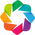

In [1]:
import pandas as pd
import numpy as np
import holoviews as hv
hv.extension('bokeh')

In [2]:
# Load in the genotype file, call it df_gt for genotype DataFrame
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])

# Rename columns
df_gt.columns = ['wt', 'het', 'mut']

# Melt to tidy
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location').dropna()

# Reset index
df_gt = df_gt.reset_index(drop=True)

# Integer location names
df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

# Read in activity data
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Merge with genotype data
df = pd.merge(df, df_gt)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Column for light or dark
df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

# Indices we want
inds = (  (~df['light'])
        & (df['day'] == 5)
        & (df['activity'] < 0.1)
        & (df['genotype'] == 'wt') )

# Pluck our data and count number of sleeping minutes; store as NumPy array
n_sleep_min = df[inds].groupby('location')['location'].count().values

# Take a look
n_sleep_min

array([303, 278, 220, 349, 328, 324, 234,  87, 292, 253, 207, 264, 181,
       186, 211, 124, 124], dtype=int64)

## Part (a)

Now, "we have 17 measurements of the number of sleep minutes on the fifth night of the life of wild type fish." Let us define this array as $x$. Let us also assume a Gaussian distribution. The formula for the Gaussian distribution is:

$$P(x \mid \mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-\mu)^2/2\sigma^2}$$


## Part (b)

From lecture 2 notes, we see that for a Jeffreys prior for $\sigma$ and a uniform prior for $\mu$, and for $n$ observations, the posterior should be

$$\frac{1}{\sigma^{n+1}}\exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i-\mu)^2\right]$$

We plot this below:

<div class="alert alert-info">
a: 0.5/1  
You wrote out the probability for a single measurement, but the likelihood for the full set of measurements (assuming they are independent) is
$$P \left( x \mid \mu, \sigma \right) = \left( \frac{1}{\sqrt{2 \pi \sigma^2}} \right)^n \exp \left( - \frac{1}{2 \sigma^2} \sum_i \left( x_i - \mu \right)^2 \right)$$
The posterior in b and your code do reflect the correct expression.
</div>

In [3]:
mu_range = np.linspace(200,260,100)
sigma_range = np.linspace(40,100,100)
xvals = np.array(n_sleep_min)
n = len(xvals)
posterior = lambda mu,sigma,n: 1/sigma**(n+1)*np.exp(-1/2/(sigma**2)*sum([(i-mu)**2 for i in xvals]))
x,y = np.meshgrid(mu_range, sigma_range)
img = hv.Image((mu_range, sigma_range, posterior(x,y,n)), datatype=['grid'])
img

:Image   [x,y]   (z)

Cool. We see that the center white dot of the gradient is around (234, 74). We can use this for comparison later.

# Part (c)
If we use a uniform prior for $\sigma$ instead of a Jeffreys prior, then the prior is identical to the Gaussian. This is shown below.

<div class="alert alert-info">
I know what you mean, but it would be more accurate to say that the posterior is proportional to the likelihood (and that the prior does not contribute to the unnormalized posterior).
</div>

In [4]:
posterior = lambda mu,sigma,n: 1/sigma**(n)*np.exp(-1/2/(sigma**2)*sum([(i-mu)**2 for i in xvals]))
x,y = np.meshgrid(mu_range, sigma_range)
img = hv.Image((mu_range, sigma_range, posterior(x,y,n)), datatype=['grid'])
img

:Image   [x,y]   (z)

There is very little difference between the contour plots between **(b)** and **(c)** which in this case indicates that both result in similar outcomes. This plot also has a center around (234, 74), with similarly shaped gradient.

# Part (d)

Here we will use an informative prior for $\mu$ and a Jeffreys prior for $\sigma$.

In [5]:
s_m = 100
mu_p = 200
prior = lambda mu,sigma: 1/sigma/s_m*np.exp(-(mu-mu_p)**2/2/s_m**2)
gaussian = lambda mu,sigma,n: 1/sigma**(n)*np.exp(-1/2/(sigma**2)*sum([(i-mu)**2 for i in xvals]))
posterior = lambda mu,sigma,n: prior(mu,sigma)*gaussian(mu,sigma,n)
x,y = np.meshgrid(mu_range, sigma_range)
img = hv.Image((mu_range, sigma_range, posterior(x,y,n)), datatype=['grid'])
img

:Image   [x,y]   (z)

Again, we see very little difference between this plot and the two before, indicating that they give us relatively similar outcomes. Center again near (234, 74), with similar gradient.

# Part (e)

In [6]:
s_m = 20
mu_p = 200
prior = lambda mu,sigma: 1/sigma/s_m*np.exp(-(mu-mu_p)**2/2/s_m**2)
gaussian = lambda mu,sigma,n: 1/sigma**(n)*np.exp(-1/2/(sigma**2)*sum([(i-mu)**2 for i in xvals]))
posterior = lambda mu,sigma,n: prior(mu,sigma)*gaussian(mu,sigma,n)
x,y = np.meshgrid(mu_range, sigma_range)
img = hv.Image((mu_range, sigma_range, posterior(x,y,n)), datatype=['grid'])
img

:Image   [x,y]   (z)

The more informative prior has given us very different results for the contour plot compared to **(b), (c), (d)**. The center has shifted closer to (218, 74), and the contour has much less spread in the x direction.

<div class="alert alert-info">
b-e: 6.5/6.5  
Excellent work!  Just a few tips for practical purposes:
<ul>
<li>It is often safer to use log priors, likelihoods, and posteriors, for numerical stability.</li>
<li>You could make your code cleaner by separating out the functions for the likelihood and the prior in b-c, just as you did in d-e.</li>
</ul>
</div>

# Part (f)

A more informative prior will give more accurate contour plot, not only shifting the center of the plot but also affecting its spread. With more generic/uncertain priors that we use such as the uniform or Jeffreys, we get similar outcomes that may not be the best representation of the data (because they are so generic and are estimations based on assmptions.

<div class="alert alert-info">
f: 2/2  
Good comparison of the uninformative, weakly informative, and strongly informative priors!  A more informative prior does not necessarily give a more ``accurate'' posterior, though; it just means that it will weight the estimates more heavily toward the prior estimate (for better or worse).
</div>

<div class="alert alert-info">
0.5/0.5  
Great job explaining your analysis clearly!  It might also be helpful to explicitly write out your likelihoods, priors, and posteriors for each case.
</div>

<div class="alert alert-info">
Total: 9.5/10
</div>